In [8]:
model_list = [
    "Tower-Babel/Babel-9B-Chat",
    "google/gemma-3-12b-it",
    "meta-llama/Llama-2-7b-chat-hf",
]

language_list = [
    "English",
    "Korean",
    "German",
]

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

version_colors = {
    "": "#1f77b4",  # Blue
    "v2": "#ff7f0e",  # Orange
    "v3": "#165a16",  # Green
    "v4": "#d62728"   # Red
}

version_linestyles = {
    "": ":",
    "v2": "--",
    "v3": "-.",
    "v4": ":"
}


model_colors = {
    "Babel-9B-Chat": "#66c2a5",
    "gemma-3-12b-it": "#fc8d62",
    "Llama-2-7b-chat-hf": "#e78ac3"
}

# Define colors for each language
language_colors = {
    "English": "#1f77b4",
    "Korean": "#ff7f0e",
    "German": "#2ca02c"
}

# Define line styles for each model
model_styles = {
    "Babel-9B-Chat": "-",
    "gemma-3-12b-it": "--",
    "Llama-2-7b-chat-hf": ":"
}

languague_styles = {
    "English": "-",
    "Korean": "--",
    "German": ":"
}

In [31]:
# load dataset
import pandas as pd
import glob
import os

# Set your directory path here
directory_path = "/home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights"

# Find all CSV files ending with "_2token.csv"
csv_files = glob.glob(os.path.join(directory_path, "*_2token.csv"))

# Load and concatenate all DataFrames
# df_list = [pd.read_csv(file) for file in csv_files]
min_length = 10000  # Set your minimum length here
for file in csv_files:
    df = pd.read_csv(file)
    print(f"File: {file}, Length: {df.shape[0]}, max_context_length: {df['context'].apply(len).max()}")
    if df.shape[0] < min_length:   
        min_length = df.shape[0]

print(f"Minimum length across all files: {min_length}")

# filter the 
df_dict = {}
for file in csv_files:
    df = pd.read_csv(file)
    df = df.sample(n=min_length, random_state=2025)  # Sample min_length rows
    df_dict[file.split('/')[-1]] = df

File: /home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights/gemma-3-12b-it_German_2token.csv, Length: 5605, max_context_length: 361
File: /home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights/gemma-3-12b-it_English_2token.csv, Length: 2488, max_context_length: 384
File: /home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights/Babel-9B-Chat_German_2token.csv, Length: 3131, max_context_length: 286
File: /home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights/Llama-2-7b-chat-hf_German_2token.csv, Length: 9469, max_context_length: 341
File: /home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights/Llama-2-7b-chat-hf_English_2token.csv, Length: 6837, max_context_length: 426
File: /home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights/Babel-9B-Chat_Korean_2token.csv, Length: 8972, max_context_length: 

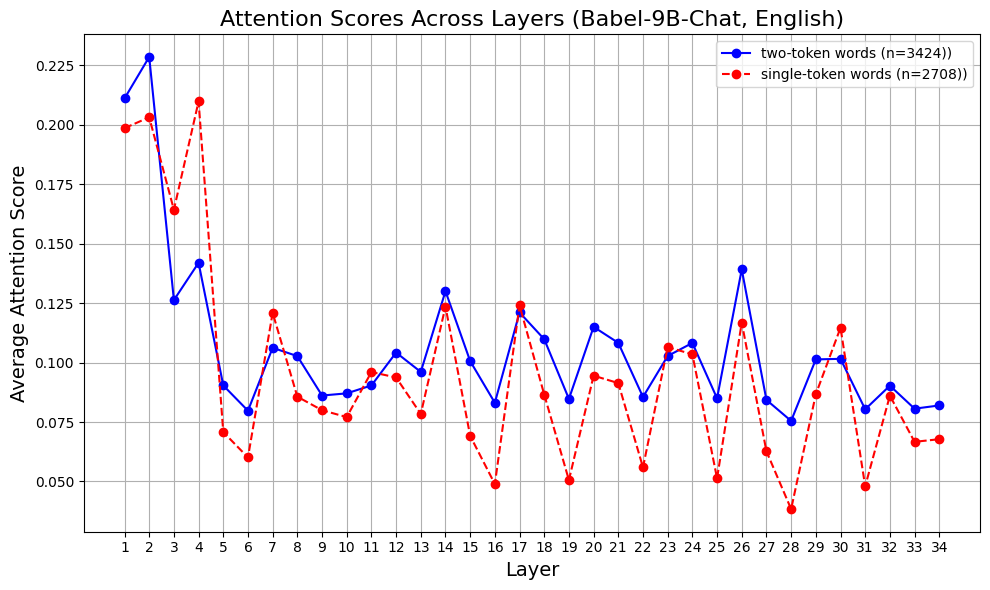

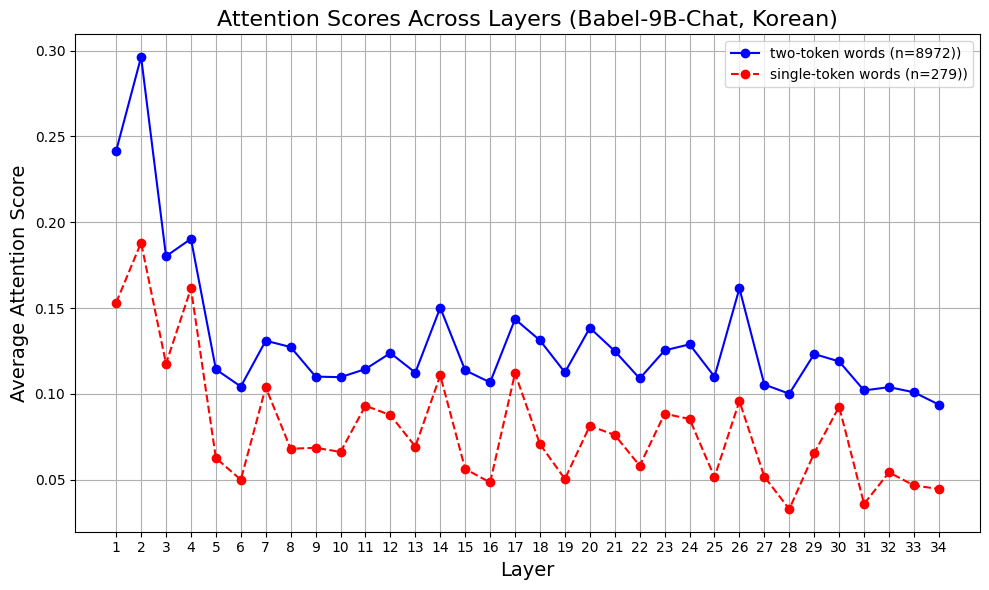

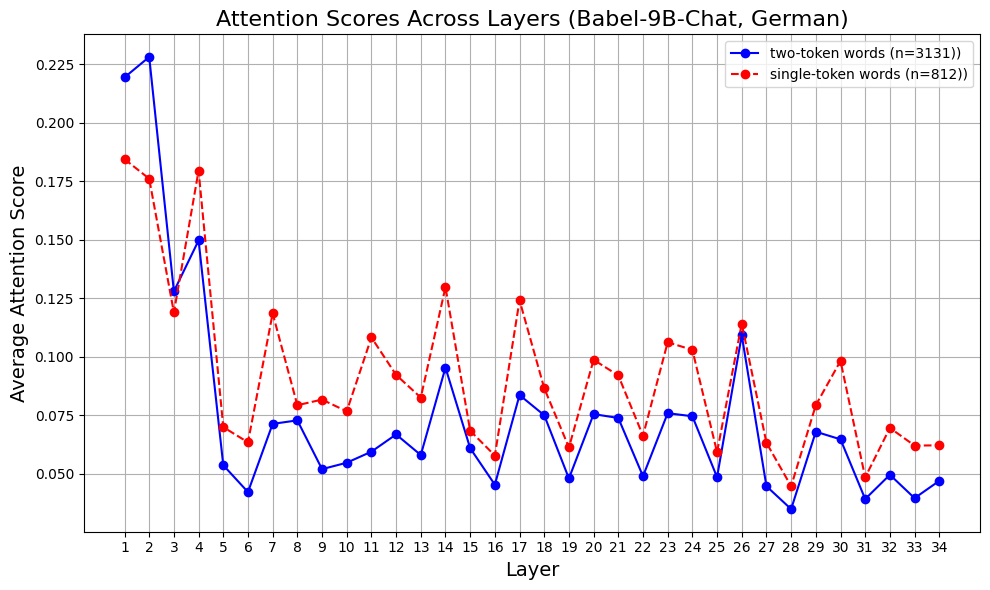

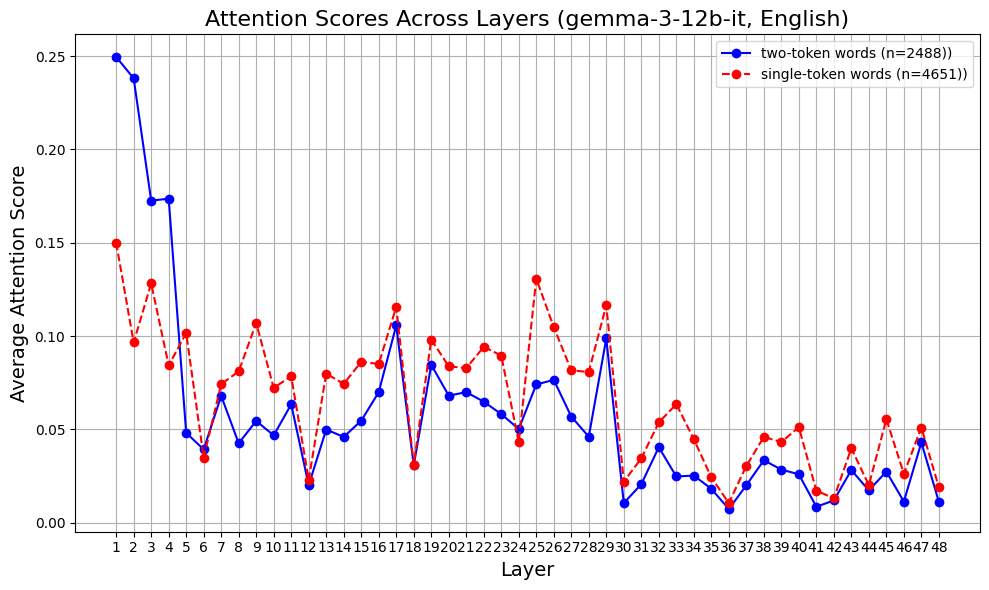

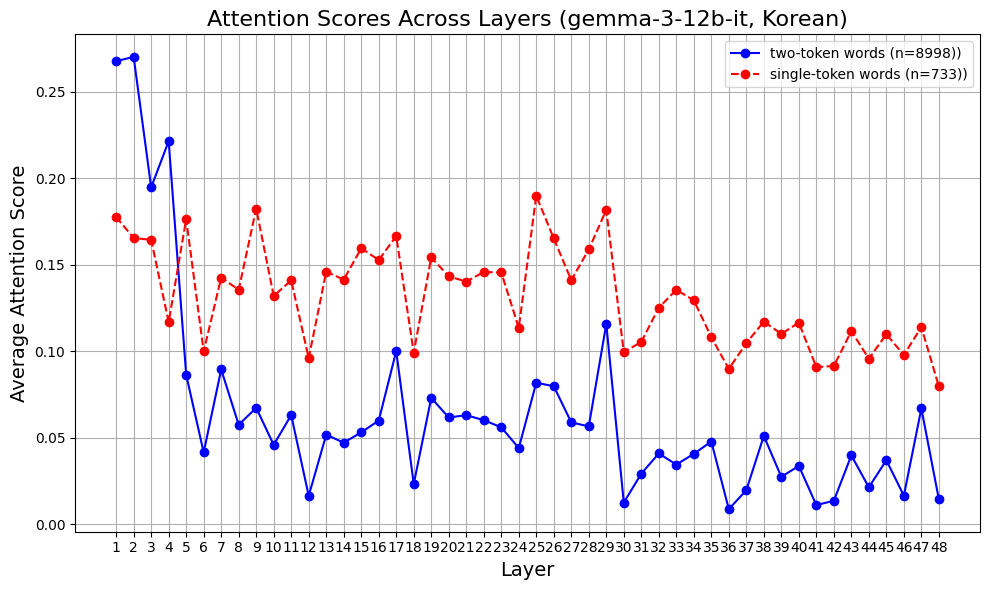

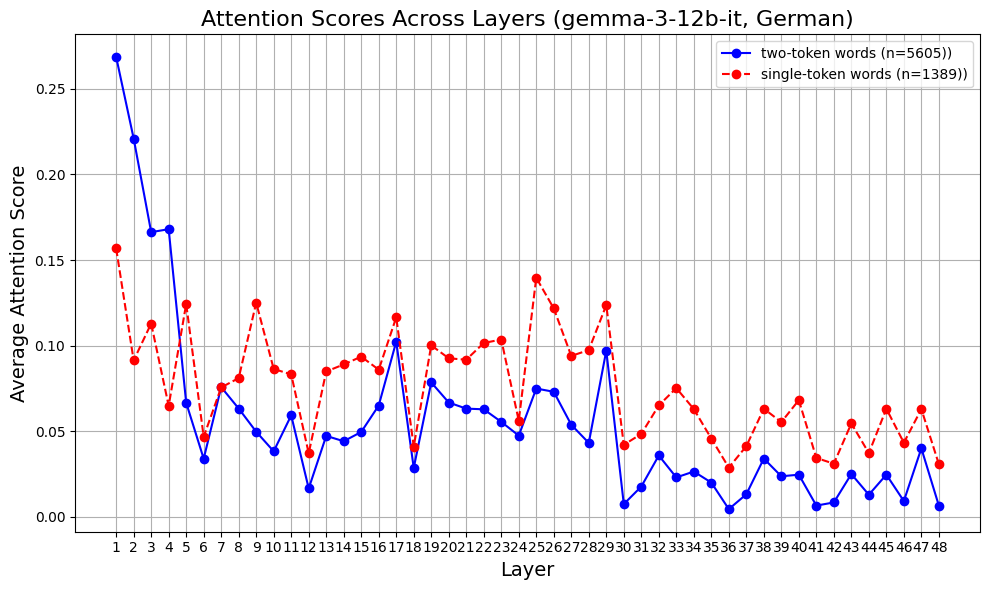

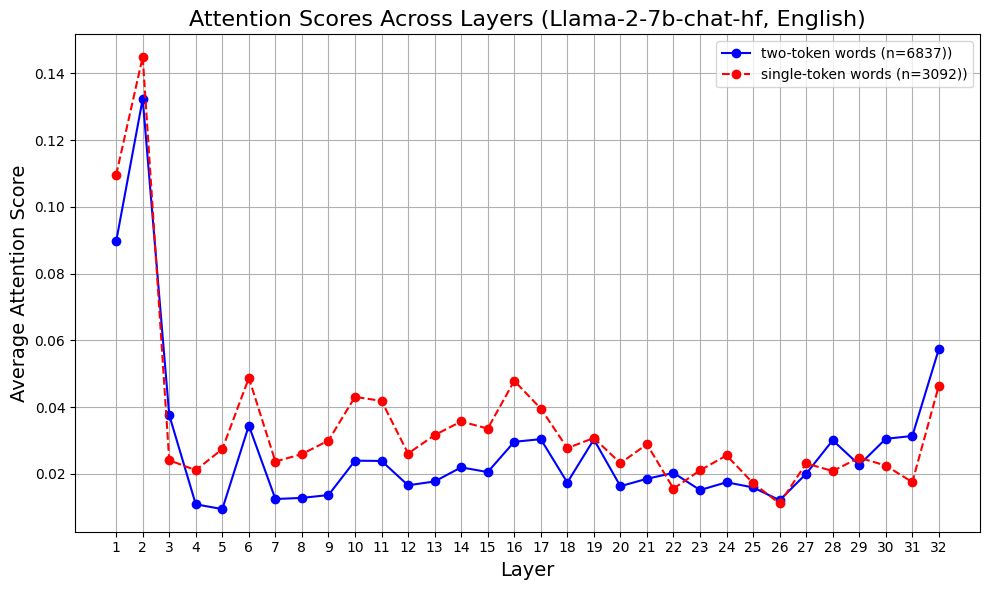

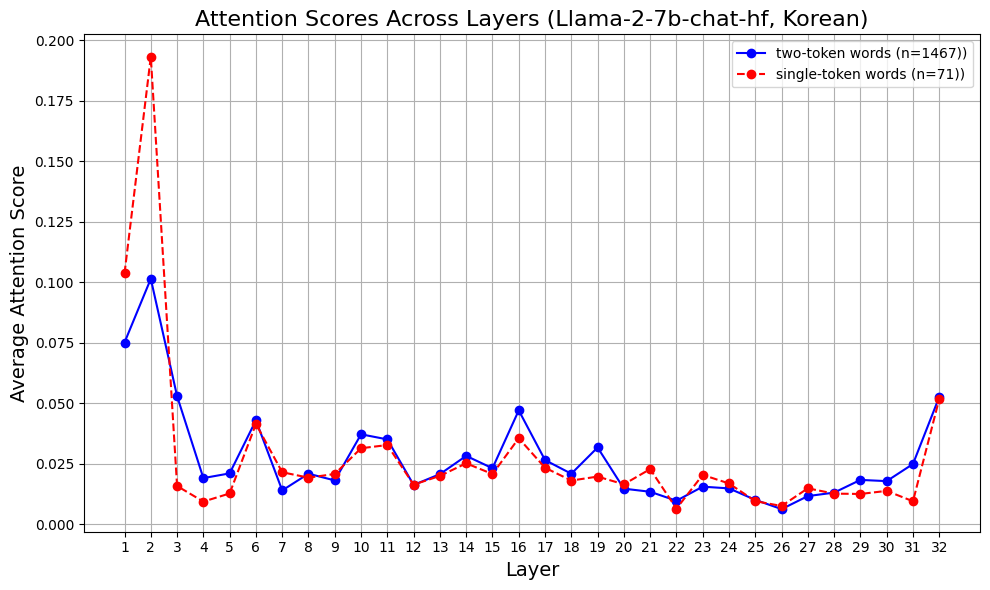

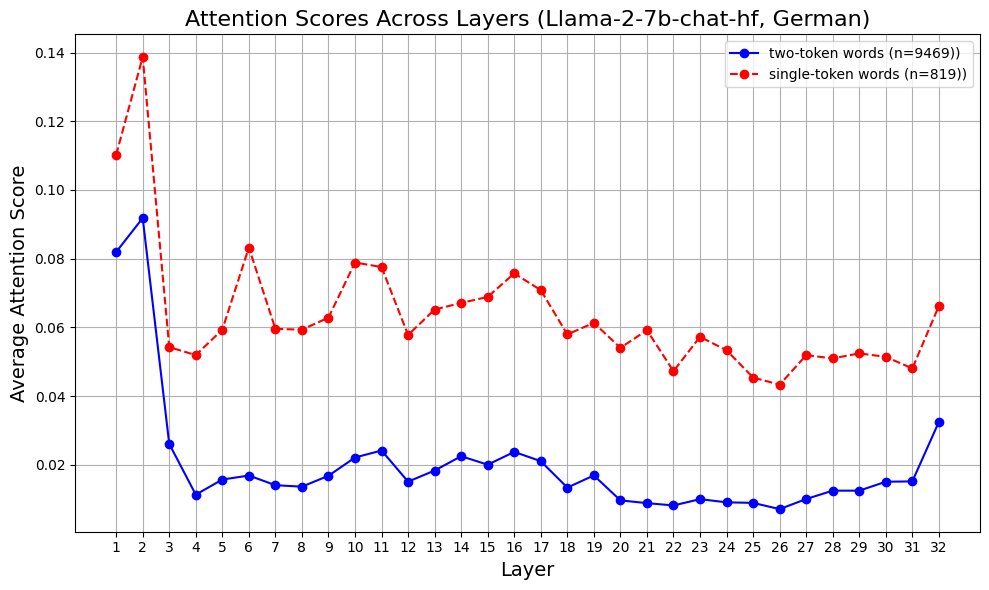

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# Define the directory path
directory_path = "/home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights"

# Iterate over each model and language pair
for model in model_list:
    for language in language_list:
        # Find the corresponding files for _2token and _single-token
        file_2token = glob.glob(os.path.join(directory_path, f"{model.split('/')[-1]}_{language}_2token.csv"))
        if not file_2token:
            print(f"File not fount: {f"{model.split('/')[-1]}_{language}__2token.csv"}")
            
        file_single_token = glob.glob(os.path.join(directory_path, f"{model.split('/')[-1]}_{language}_single-token.csv"))
        if not file_single_token:
            print(f"File not fount: {f"{model.split('/')[-1]}_{language}_*_single-token.csv"}")
            continue

        # Load the DataFrames
        df_2token = pd.read_csv(file_2token[0])
        df_single_token = pd.read_csv(file_single_token[0])

        # Extract layer-wise attention columns
        layer_columns = [col for col in df_2token.columns if col.startswith("layer_")]

        # Compute the average attention scores for each layer
        avg_attention_2token = df_2token[layer_columns].mean()
        avg_attention_single_token = df_single_token[layer_columns].mean()

        # Plot the attention scores
        plt.figure(figsize=(10, 6))
        plt.plot(
            range(1, len(avg_attention_2token) + 1),
            avg_attention_2token,
            marker='o',
            linestyle='-',
            color='b',
            label=f'two-token words (n={len(df_2token)}))'
        )
        plt.plot(
            range(1, len(avg_attention_single_token) + 1),
            avg_attention_single_token,
            marker='o',
            linestyle='--',
            color='r',
            label=f'single-token words (n={len(df_single_token)}))'
        )

        # Customize the plot
        plt.title(f"Attention Scores Across Layers ({model.split('/')[-1]}, {language})", fontsize=16)
        plt.xlabel("Layer", fontsize=14)
        plt.ylabel("Average Attention Score", fontsize=14)
        plt.xticks(range(1, len(avg_attention_2token) + 1))  # Ensure x-axis ticks match layer numbers
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        # Show the plot
        plt.show()

In [27]:
# Set your directory path here
directory_path = "/home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights"

# Find all CSV files ending with "_2token.csv"
csv_files = glob.glob(os.path.join(directory_path, "*_single-token.csv"))

# Load and concatenate all DataFrames
# df_list = [pd.read_csv(file) for file in csv_files]
min_length = 10000  # Set your minimum length here
for file in csv_files:
    df = pd.read_csv(file)
    print(f"File: {file}, Length: {df.shape[0]}, max_context_length: {df['context'].apply(len).max()}")
    if df.shape[0] < min_length:   
        min_length = df.shape[0]

print(f"Minimum length across all files: {min_length}")



File: /home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights/Babel-9B-Chat_Korean_single-token.csv, Length: 279, max_context_length: 145
File: /home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights/gemma-3-12b-it_English_single-token.csv, Length: 4651, max_context_length: 449
File: /home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights/Llama-2-7b-chat-hf_English_single-token.csv, Length: 3092, max_context_length: 293
File: /home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights/Llama-2-7b-chat-hf_German_single-token.csv, Length: 819, max_context_length: 216
File: /home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights/gemma-3-12b-it_German_single-token.csv, Length: 1389, max_context_length: 303
File: /home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights/Babel-9B-Chat_German_single-token.csv, 

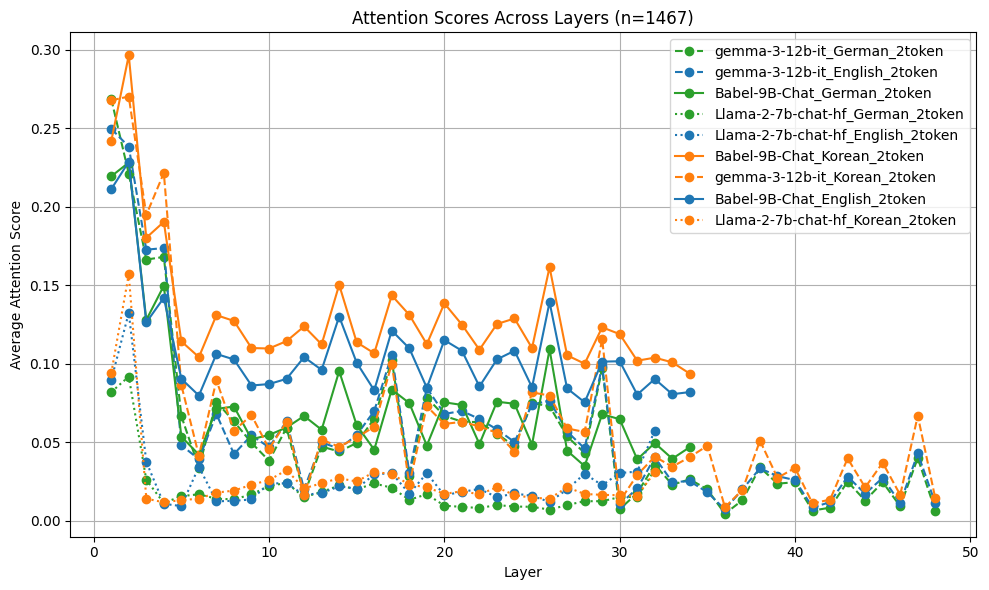

In [34]:
plt.figure(figsize=(10, 6))

for path in csv_files:
    # Extract model and language from the file name
    df = pd.read_csv(path)
    df.sample(n=1467, random_state=2025, replace=True)  # Sample min_length rows
    filename = os.path.basename(path)
    model_short = filename.split("_")[0]
    lang = filename.split("_")[1]
    
    # Extract layer-wise attention columns
    layer_columns = [col for col in df.columns if col.startswith("layer_")]

    # Compute the average attention score for each layer
    avg_attention_scores = df[layer_columns].mean()
    
    # Plot
    plt.plot(
        range(1, len(avg_attention_scores) + 1),
        avg_attention_scores,
        marker='o',
        label = filename.split(".")[0],
        color=language_colors.get(lang, "black"),  # Use the color for the language
        linestyle=model_styles.get(model_short, "dashdot"),  # Use the line style for the model
    )

plt.xlabel("Layer")
plt.ylabel("Average Attention Score")
plt.title("Attention Scores Across Layers (n=1467)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_1363943/1720685945.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=melted_df, x="layer", y="attention_score", ci="sd", marker="o")


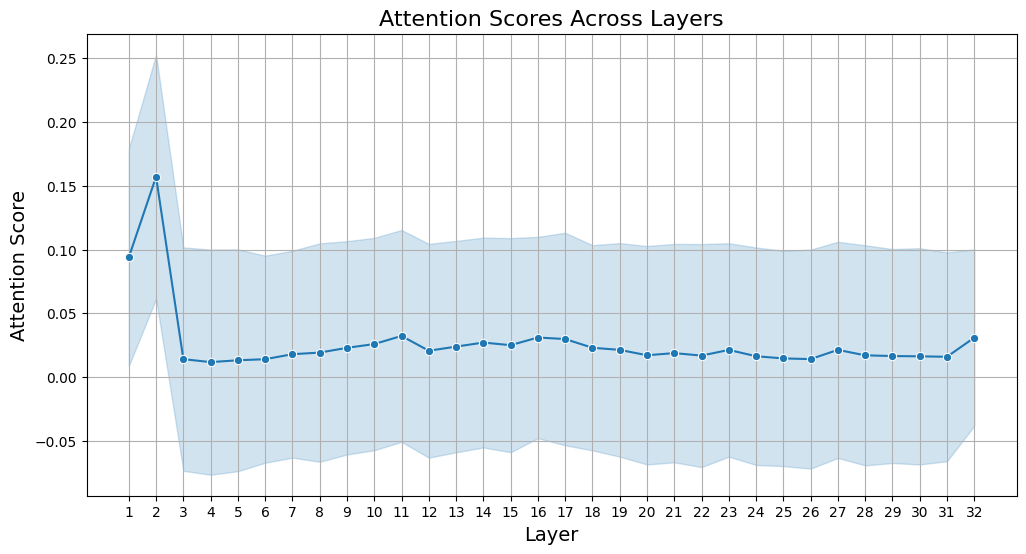

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame to make it suitable for seaborn
layer_columns = [col for col in df.columns if col.startswith("layer_")]
melted_df = df.melt(
    id_vars=["word", "context"],  # Keep these columns as identifiers
    value_vars=layer_columns,    # Columns to unpivot
    var_name="layer",            # Name for the new 'layer' column
    value_name="attention_score" # Name for the new 'attention_score' column
)

# Convert layer names to integers for proper sorting
melted_df["layer"] = melted_df["layer"].str.extract(r"(\d+)").astype(int)

# Plot the lineplot
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x="layer", y="attention_score", ci="sd", marker="o")

# Customize the plot
plt.title("Attention Scores Across Layers", fontsize=16)
plt.xlabel("Layer", fontsize=14)
plt.ylabel("Attention Score", fontsize=14)
plt.xticks(range(1, melted_df["layer"].max() + 1))  # Ensure x-axis ticks match layer numbers
plt.grid(True)
plt.show()

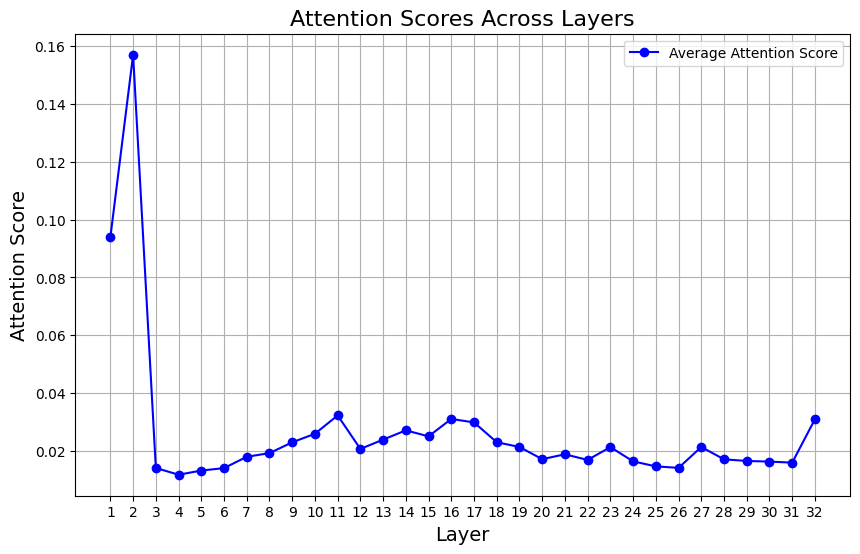

In [20]:
import matplotlib.pyplot as plt

# Extract layer-wise attention columns
layer_columns = [col for col in df.columns if col.startswith("layer_")]

# Compute the average attention score for each layer
avg_attention_scores = df[layer_columns].mean()

# Plot the attention scores
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(avg_attention_scores) + 1),  # X-axis: Layer numbers
    avg_attention_scores,                    # Y-axis: Average attention scores
    marker='o', linestyle='-', color='b', label='Average Attention Score'
)

# Customize the plot
plt.title("Attention Scores Across Layers", fontsize=16)
plt.xlabel("Layer", fontsize=14)
plt.ylabel("Attention Score", fontsize=14)
plt.xticks(range(1, len(avg_attention_scores) + 1))  # Ensure x-axis ticks match layer numbers
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the attention weights DataFrame
attn_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/attention_weights/{MODEL_NAME.split('/')[-1]}_{LANGUAGE}_all.csv")

# Extract layer-wise attention columns
layer_columns = [col for col in attn_df.columns if col.startswith("layer_")]

# Compute the average attention weight for each layer
avg_attn_weights = attn_df[layer_columns].mean()

# Plot the average attention weights
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(avg_attn_weights) + 1), avg_attn_weights, marker='o', linestyle='-', color='b')
plt.title(f"Average Attention Weights Across Layers ({MODEL_NAME}, {LANGUAGE})", fontsize=14)
plt.xlabel("Layer", fontsize=12)
plt.ylabel("Average Attention Weight", fontsize=12)
plt.xticks(range(1, len(avg_attn_weights) + 1))  # Ensure x-axis ticks match layer numbers
plt.grid(True)
plt.show()